### Summary of Akshita's Setup
- **Step 1**: Map compute (N, D) to task loss (bpb on CF continuation). *Only the final checkpoints are used*
- **Step 2**: Map task loss (bpb on CF) to task score (accuracy) using sigmoid.

Additional hacks:
1. **2 additional points**: Additional points added for perfect score (bpb=0.01, accuracy=1) and random chance (bpb=2.6, accuracy=0.25). bpb=2.6 is arbitrarily chosen
2. **Moving average**: Use moving average with window size = 20. 20 is arbitrarily chosen
3. **Expontential moving average**: Use EMA with alpha=0.5
4. **Last n% of points**: Instead of all bpb, only use the last 2% of points per run. 2% is arbitrary.

Notes:
- BoolQ is removed from aggregate scores due to noise

Experimental settings:
- **Easy**: Use every model up to the target model
- **Hard**: Use models with 1/10th the training tokens of the target model

In [1]:
%load_ext autoreload
%autoreload 2

### Setup (Pull W&B Logs)

In [2]:
from olmo.scaling.scaling_laws.download_wandb_logs import main as download_wb
from a_david_noise_utils import get_name_size_length
from argparse import Namespace
import os
import itertools

WANDB_RESULTS = "wandb/peteish-final"
FIGURES = "figures"

run_names = [
    f"ai2-llm/olmo-ladder/peteish-final-{size}-{length}"
    for size, length in itertools.product(["190M", "370M", "600M", "760M", "1B"], ["1xC", "2xC", "5xC", "10xC"])
]

validation_outputs = {}
for run_name in run_names:
    if "peteish7" in run_name:
        output_name = "peteish7"
    else:
        output_name = run_name.split("/")[-1]
        name, size, length = get_name_size_length(run_name)
        output_name = f"{size}-{length}"
    output_path = f"{WANDB_RESULTS}/{output_name}.csv"
    args = Namespace(
        wandb_names=[run_name],
        # x_axis="throughput/total_tokens",
        x_axis="_step",
        y_axis=["eval/validation-and-bpb-and-downstream"],
        output_path=output_path,
        eval_only=False
    )
    if not os.path.exists(output_path):
        download_wb(args)
    validation_outputs[output_name] = output_path

/Users/dhei/miniconda3/envs/olmo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Hard Setting

In [3]:
import ladder_peteish as ladder

# Find the model size corresponding to 10x less compute
all_flops = []
for size in ["190M", "370M", "600M", "760M", "1B"]:
    paths = []
    for length in ["1xC", "2xC", "5xC", "10xC"]:
        if size == "3B" and length == "10xC":
            break
        model_flops = ladder.MODEL_GFLOPS[size]
        length_in_tokens = ladder.parse_length(length, ladder.parse_size(size))
        total_flops = (model_flops * length_in_tokens) / 1e18
        all_flops.append((f"{size}-{length}", total_flops))
sorted_by_flops = sorted(all_flops, key=lambda x:x[1])
corresponding_flops_10x = {
    "1B-10xC": "1B-1xC",
}

# for tup in sorted_by_flops:
#     print(tup)
# print("Using generous upper-bounds to find nearest corresponding 10x less flops run")
# for key, val in corresponding_flops_10x.items():
#     print(f"{key} uses upto {val}")

In [4]:
from a_david_noise_utils import COLOR_MAP, N_LAST_CKPTS
from olmo.scaling.scaling_laws.utils import FinalConfig

all_configs = []

for run_name, max_train_run in corresponding_flops_10x.items():
    configs_size = {}
    for (train_run, _) in sorted_by_flops:
        
        train_size, train_length = train_run.split("-")
        if train_size in configs_size:
            configs_size[train_size]["paths"].append(f"wandb/peteish-final/{train_run}.csv")
        else:
            configs_size[train_size] = {
                "paths": [f"wandb/peteish-final/{train_run}.csv"],
                "mode": "train",
                "n": ladder.MODEL_PARAMS[train_size],
                "label": train_size,
                "color": COLOR_MAP[train_size]
            }

        if train_run == max_train_run:
            break

    size, length = run_name.split("-")
    configs_size[f"{size}-{length}"] = {
        "paths": [f"wandb/peteish-final/{run_name}.csv"],
        "mode": "eval",
        "n": ladder.MODEL_PARAMS[size],
        "label": size,
        "color": COLOR_MAP[size]
    }
    configs_size = {name: FinalConfig(**config) for name, config in configs_size.items()}
    all_configs.append(configs_size)

#### Predicting 1B at 10xC

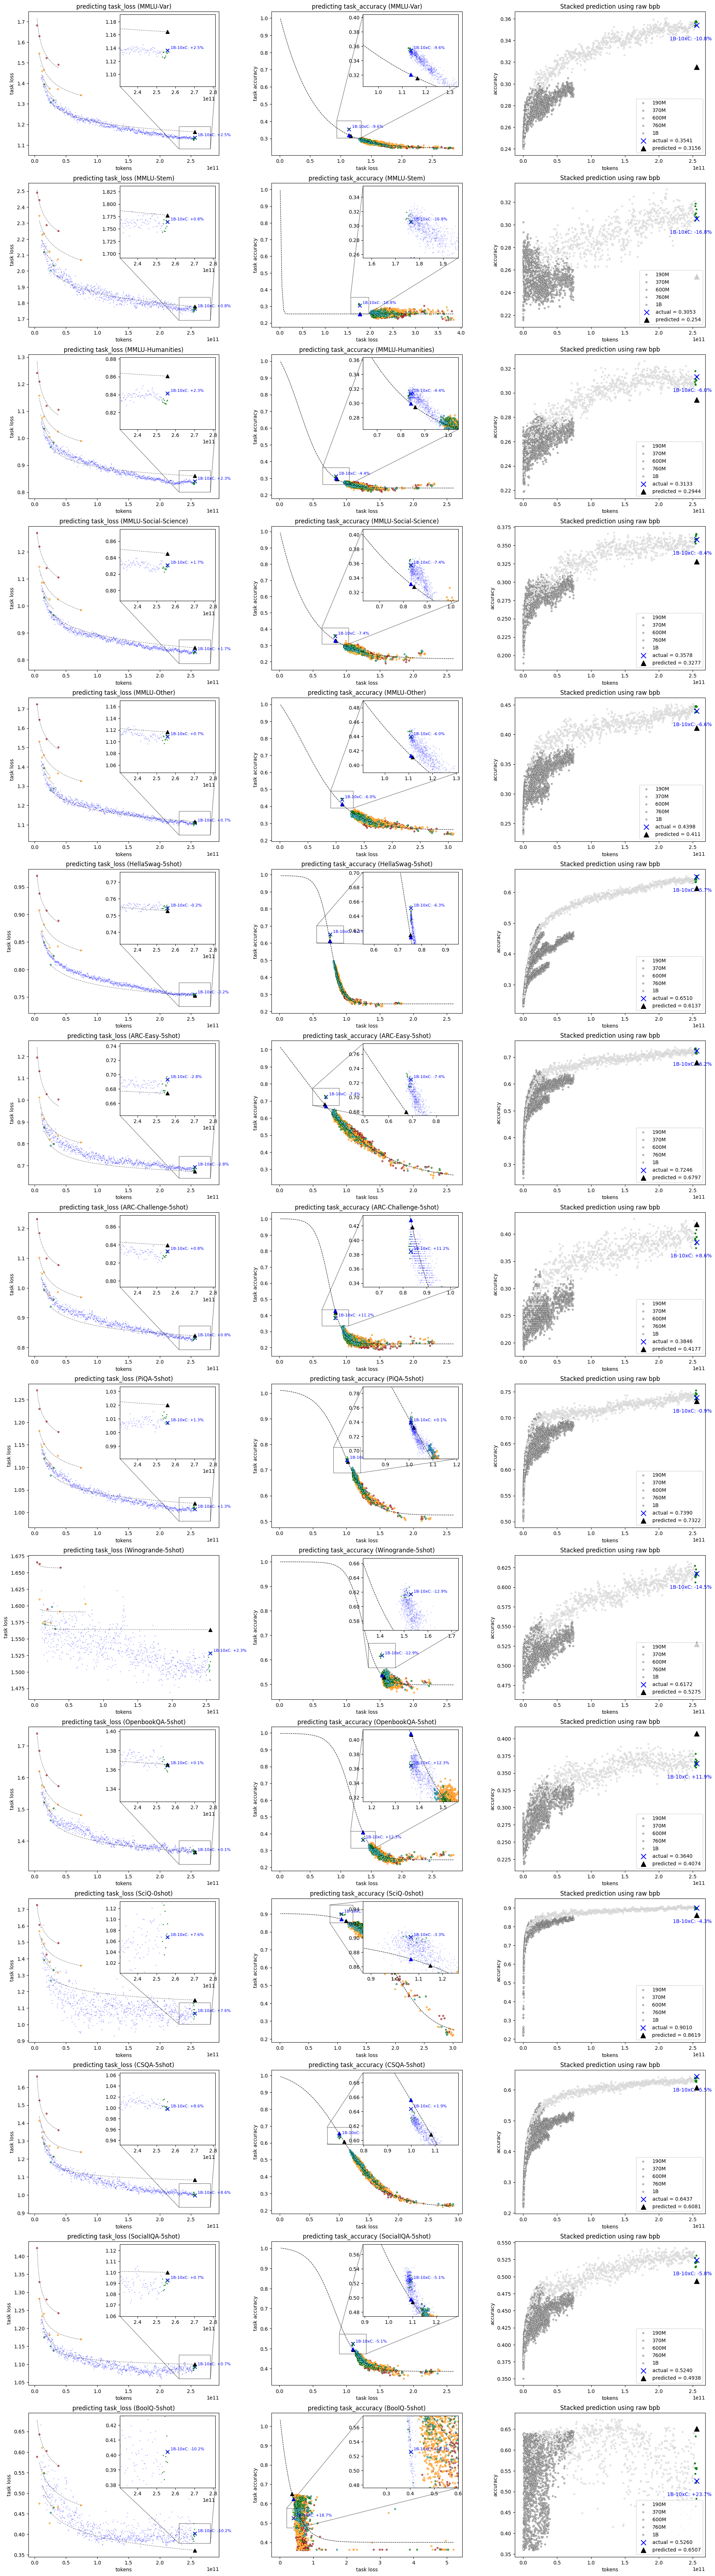

In [5]:
# from a_david_noise_utils import get_all_data_by_name, get_dataframe, plot_step1, plot_step2, fit_step1, fit_step2, get_predicted_error, get_last_n_predicted_error, plot_stacked, run_stacked
# from a_david_noise_utils import BASELINE_BY_TASK_NAME, TASKS
# import matplotlib.pyplot as plt

from a_david_noise_utils import run_stacked

step1_error, step2_error, stacked_error = run_stacked(all_configs)

In [6]:
print('Errors for the prediction target (blue X)')
print('Note: "Step 2 ONLY" means that we use the gold task loss to predict the task accuracy, so this shows the error of step 2 if the step 1 predictions are perfect.')
from a_david_noise_utils import print_step_error_table
print_step_error_table(step1_error, step2_error, stacked_error)

Errors for the prediction target (blue X)
Note: "Step 2 ONLY" means that we use the gold task loss to predict the task accuracy, so this shows the error of step 2 if the step 1 predictions are perfect.


| Task | Step 1 error (1B-10xC) |Step 2 error (1B-10xC) |Stacked error (1B-10xC) |
| --- | --- | --- | --- |
| MMLU-Var | +2.5% | -9.6% | -10.8% |
| MMLU-Stem | +0.8% | -16.8% | -16.8% |
| MMLU-Humanities | +2.3% | -4.4% | -6.0% |
| MMLU-Social-Science | +1.7% | -7.4% | -8.4% |
| MMLU-Other | +0.7% | -6.0% | -6.6% |
| HellaSwag-5shot | -0.2% | -6.3% | -5.7% |
| ARC-Easy-5shot | -2.8% | -7.4% | -6.2% |
| ARC-Challenge-5shot | +0.8% | +11.2% | +8.6% |
| PiQA-5shot | +1.3% | +0.1% | -0.9% |
| Winogrande-5shot | +2.3% | -12.9% | -14.5% |
| OpenbookQA-5shot | +0.1% | +12.3% | +11.9% |
| SciQ-0shot | +7.6% | -3.3% | -4.3% |
| CSQA-5shot | +8.6% | +1.9% | -5.5% |
| SocialIQA-5shot | +0.7% | -5.1% | -5.8% |
| BoolQ-5shot | -10.2% | +18.7% | +23.7% |
| **Avg unsigned stacked error** (excl. BoolQ, MMLU subsets) | **+2.7%** |**+7.0%** |**+7.4%** |

In [7]:
print(f'Errors when averaging the prediction target over the last {N_LAST_CKPTS} checkpoints (using the green X instead of the blue X):')
print_step_error_table(step1_error, step2_error, stacked_error, entry_value='rel_error_lastn_mean')

Errors when averaging the prediction target over the last 10 checkpoints (using the green X instead of the blue X):


| Task | Step 1 error (1B-10xC) |Step 2 error (1B-10xC) |Stacked error (1B-10xC) |
| --- | --- | --- | --- |
| MMLU-Var | +3.0% | -10.1% | -11.4% |
| MMLU-Stem | +1.2% | -18.1% | -18.1% |
| MMLU-Humanities | +3.3% | -3.7% | -5.3% |
| MMLU-Social-Science | +2.2% | -7.8% | -8.9% |
| MMLU-Other | +0.9% | -6.9% | -7.5% |
| HellaSwag-5shot | -0.3% | -5.0% | -4.5% |
| ARC-Easy-5shot | -1.5% | -7.3% | -6.1% |
| ARC-Challenge-5shot | +1.3% | +9.4% | +6.8% |
| PiQA-5shot | +1.0% | -0.5% | -1.5% |
| Winogrande-5shot | +3.5% | -12.9% | -14.5% |
| OpenbookQA-5shot | +0.0% | +11.8% | +11.4% |
| SciQ-0shot | +5.9% | -3.1% | -4.1% |
| CSQA-5shot | +7.9% | +3.5% | -4.0% |
| SocialIQA-5shot | +1.0% | -4.5% | -5.2% |
| BoolQ-5shot | -9.6% | +15.5% | +20.3% |
| **Avg unsigned stacked error** (excl. BoolQ, MMLU subsets) | **+2.5%** |**+6.8%** |**+7.0%** |

In [8]:
print(f'Standard deviation of the last {N_LAST_CKPTS} prediction targets:')
print_step_error_table(step1_error=step1_error, stacked_error=stacked_error, entry_value='y_lastn_std')

Standard deviation of the last 10 prediction targets:


| Task | Target task loss std. dev. (1B-10xC) |Target accuracy std. dev. (1B-10xC) |
| --- | --- | --- |
| MMLU-Var | 0.388e-02 | 0.157e-02 |
| MMLU-Stem | 0.915e-02 | 0.458e-02 |
| MMLU-Humanities | 0.333e-02 | 0.313e-02 |
| MMLU-Social-Science | 0.226e-02 | 0.446e-02 |
| MMLU-Other | 0.473e-02 | 0.404e-02 |
| HellaSwag-5shot | 0.085e-02 | 0.684e-02 |
| ARC-Easy-5shot | 0.689e-02 | 0.707e-02 |
| ARC-Challenge-5shot | 0.254e-02 | 0.915e-02 |
| PiQA-5shot | 0.270e-02 | 0.492e-02 |
| Winogrande-5shot | 1.229e-02 | 0.550e-02 |
| OpenbookQA-5shot | 0.466e-02 | 0.535e-02 |
| SciQ-0shot | 3.144e-02 | 0.298e-02 |
| CSQA-5shot | 0.623e-02 | 0.577e-02 |
| SocialIQA-5shot | 0.332e-02 | 0.542e-02 |
| BoolQ-5shot | 1.187e-02 | 4.432e-02 |
| **Avg unsigned target accuracy std. dev.** (excl. BoolQ, MMLU subsets) | **0.748e-02** |**0.546e-02** |

In [9]:
from IPython.display import display, Markdown
print(f'Coefficient of variation of the last {N_LAST_CKPTS} prediction targets:')
display(Markdown(r'$$\text{CV} = \frac{\sigma}{\bar{x}}$$'))
print_step_error_table(step1_error=step1_error, stacked_error=stacked_error, entry_value='y_lastn_coeff_var')

Coefficient of variation of the last 10 prediction targets:


$$\text{CV} = \frac{\sigma}{\bar{x}}$$

| Task | Target task loss coefficient of variation (1B-10xC) |Target accuracy coefficient of variation (1B-10xC) |
| --- | --- | --- |
| MMLU-Var | 0.34% | 0.44% |
| MMLU-Stem | 0.52% | 1.48% |
| MMLU-Humanities | 0.40% | 1.01% |
| MMLU-Social-Science | 0.27% | 1.24% |
| MMLU-Other | 0.43% | 0.91% |
| HellaSwag-5shot | 0.11% | 1.07% |
| ARC-Easy-5shot | 1.01% | 0.98% |
| ARC-Challenge-5shot | 0.31% | 2.34% |
| PiQA-5shot | 0.27% | 0.66% |
| Winogrande-5shot | 0.81% | 0.89% |
| OpenbookQA-5shot | 0.34% | 1.46% |
| SciQ-0shot | 2.90% | 0.33% |
| CSQA-5shot | 0.62% | 0.91% |
| SocialIQA-5shot | 0.30% | 1.04% |
| BoolQ-5shot | 2.97% | 8.20% |
| **Avg unsigned target accuracy coefficient of variation** (excl. BoolQ, MMLU subsets) | **0.70%** |**1.01%** |

In [10]:
print(f'Number of standard deviations from the mean (z-score) of last {N_LAST_CKPTS} prediction target ckpts:')
print_step_error_table(step1_error=step1_error, stacked_error=stacked_error, entry_value='y_lastn_z_score')

Number of standard deviations from the mean (z-score) of last 10 prediction target ckpts:


| Task | Target task loss z-score (1B-10xC) |Target accuracy z-score (1B-10xC) |
| --- | --- | --- |
| MMLU-Var | 8.7 | -25.8 |
| MMLU-Stem | 2.3 | -12.3 |
| MMLU-Humanities | 8.3 | -5.3 |
| MMLU-Social-Science | 7.9 | -7.1 |
| MMLU-Other | 2.2 | -8.2 |
| HellaSwag-5shot | -2.3 | -4.2 |
| ARC-Easy-5shot | -1.5 | -6.2 |
| ARC-Challenge-5shot | 4.4 | 2.9 |
| PiQA-5shot | 3.6 | -2.3 |
| Winogrande-5shot | 4.3 | -16.2 |
| OpenbookQA-5shot | 0.1 | 7.8 |
| SciQ-0shot | 2.0 | -12.5 |
| CSQA-5shot | 12.7 | -4.4 |
| SocialIQA-5shot | 3.2 | -5.0 |
| BoolQ-5shot | -3.2 | 2.5 |
| **Avg unsigned target accuracy z-score** (excl. BoolQ, MMLU subsets) | **4.3** |**8.7** |

In [11]:
# from IPython.display import display, Markdown
# print(f'Standardized score (assuming uniform dist.) of last {N_LAST_CKPTS} prediction target ckpts:')
# display(Markdown(r"$$\text{Standardized score} = \frac{X - \mu}{\frac{b - a}{\sqrt{12}}}$$"))
# print_step_error_table(step1_error=step1_error, stacked_error=stacked_error, entry_value='y_lastn_std_score')

In [12]:
# print(f'Std dev (assuming uniform dist.) of last {N_LAST_CKPTS} prediction target ckpts:')
# display(Markdown(r"$$\sigma = \frac{b - a}{\sqrt{12}}$$"))
# print_step_error_table(step1_error=step1_error, stacked_error=stacked_error, entry_value='y_lastn_std_uniform')

In [13]:
# from a_david_noise_utils import plot_std_dev
# plot_std_dev(step1_error, stacked_error)

In [14]:
# Test out tricks to improve fit
print(f"Original setup (error on avg. of last {N_LAST_CKPTS} prediction checkpoints):")

step1_error, step2_error, stacked_error = run_stacked(all_configs, render_plot=False)
print_step_error_table(step1_error, step2_error, stacked_error, entry_value='rel_error_lastn_mean')

print(f"Original setup + Only use last 2% of checkpoints (error on avg. of last {N_LAST_CKPTS} prediction checkpoints):")

step1_error, step2_error, stacked_error = run_stacked(all_configs, limit_ckpts='last_n', render_plot=False)
print_step_error_table(step1_error, step2_error, stacked_error, entry_value='rel_error_lastn_mean')

print(f"Original setup + EMA (error on avg. of last {N_LAST_CKPTS} prediction checkpoints):")

step1_error, step2_error, stacked_error = run_stacked(all_configs, smoothing='ema', render_plot=False)
print_step_error_table(step1_error, step2_error, stacked_error, entry_value='rel_error_lastn_mean')

print(f"Original setup + EMA + Only use last 2% of checkpoints (error on avg. of last {N_LAST_CKPTS} prediction checkpoints):")

step1_error, step2_error, stacked_error = run_stacked(all_configs, smoothing='ema', limit_ckpts='last_n', render_plot=False)
print_step_error_table(step1_error, step2_error, stacked_error, entry_value='rel_error_lastn_mean')

print(f"Original setup + Only use last checkpoint (error on avg. of last {N_LAST_CKPTS} prediction checkpoints):")

step1_error, step2_error, stacked_error = run_stacked(all_configs, limit_ckpts='final', render_plot=False)
print_step_error_table(step1_error, step2_error, stacked_error, entry_value='rel_error_lastn_mean')

Original setup (error on avg. of last 10 prediction checkpoints):


| Task | Step 1 error (1B-10xC) |Step 2 error (1B-10xC) |Stacked error (1B-10xC) |
| --- | --- | --- | --- |
| MMLU-Var | +3.0% | -10.1% | -11.4% |
| MMLU-Stem | +1.2% | -18.1% | -18.1% |
| MMLU-Humanities | +3.3% | -3.7% | -5.3% |
| MMLU-Social-Science | +2.2% | -7.8% | -8.9% |
| MMLU-Other | +0.9% | -6.9% | -7.5% |
| HellaSwag-5shot | -0.3% | -5.0% | -4.5% |
| ARC-Easy-5shot | -1.5% | -7.3% | -6.1% |
| ARC-Challenge-5shot | +1.3% | +9.4% | +6.8% |
| PiQA-5shot | +1.0% | -0.5% | -1.5% |
| Winogrande-5shot | +3.5% | -12.9% | -14.5% |
| OpenbookQA-5shot | +0.0% | +11.8% | +11.4% |
| SciQ-0shot | +5.9% | -3.1% | -4.1% |
| CSQA-5shot | +7.9% | +3.5% | -4.0% |
| SocialIQA-5shot | +1.0% | -4.5% | -5.2% |
| BoolQ-5shot | -9.6% | +15.5% | +20.3% |
| **Avg unsigned stacked error** (excl. BoolQ, MMLU subsets) | **+2.5%** |**+6.8%** |**+7.0%** |

Original setup + Only use last 2% of checkpoints (error on avg. of last 10 prediction checkpoints):


| Task | Step 1 error (1B-10xC) |Step 2 error (1B-10xC) |Stacked error (1B-10xC) |
| --- | --- | --- | --- |
| MMLU-Var | +3.0% | -10.5% | -11.9% |
| MMLU-Stem | +1.2% | -19.0% | -19.0% |
| MMLU-Humanities | +3.3% | -1.8% | -3.9% |
| MMLU-Social-Science | +2.2% | -12.5% | -13.2% |
| MMLU-Other | +0.9% | -6.1% | -6.7% |
| HellaSwag-5shot | -0.3% | -2.1% | -1.5% |
| ARC-Easy-5shot | -1.5% | -7.7% | -6.5% |
| ARC-Challenge-5shot | +1.3% | +22.4% | +18.8% |
| PiQA-5shot | +1.0% | +0.0% | -1.0% |
| Winogrande-5shot | +3.5% | -12.3% | -13.7% |
| OpenbookQA-5shot | +0.0% | +13.9% | +13.5% |
| SciQ-0shot | +5.9% | -1.5% | -3.1% |
| CSQA-5shot | +7.9% | +2.9% | -4.8% |
| SocialIQA-5shot | +1.0% | -4.3% | -4.9% |
| BoolQ-5shot | -9.6% | +20.9% | +28.0% |
| **Avg unsigned stacked error** (excl. BoolQ, MMLU subsets) | **+2.5%** |**+7.8%** |**+8.0%** |

Original setup + EMA (error on avg. of last 10 prediction checkpoints):


| Task | Step 1 error (1B-10xC) |Step 2 error (1B-10xC) |Stacked error (1B-10xC) |
| --- | --- | --- | --- |
| MMLU-Var | +3.5% | -9.9% | -11.6% |
| MMLU-Stem | +2.0% | -18.1% | -18.1% |
| MMLU-Humanities | +2.9% | -3.7% | -5.3% |
| MMLU-Social-Science | +2.2% | -7.8% | -9.0% |
| MMLU-Other | +1.5% | -6.3% | -7.5% |
| HellaSwag-5shot | -0.0% | -4.8% | -4.8% |
| ARC-Easy-5shot | -1.3% | -7.3% | -6.3% |
| ARC-Challenge-5shot | +1.5% | +10.5% | +6.9% |
| PiQA-5shot | +1.4% | -0.4% | -1.8% |
| Winogrande-5shot | +3.8% | -11.4% | -14.3% |
| OpenbookQA-5shot | +0.2% | +12.8% | +11.5% |
| SciQ-0shot | +9.4% | -0.8% | -3.2% |
| CSQA-5shot | +8.9% | +3.4% | -4.8% |
| SocialIQA-5shot | +0.9% | -4.4% | -5.1% |
| BoolQ-5shot | +5.6% | +18.9% | +16.1% |
| **Avg unsigned stacked error** (excl. BoolQ, MMLU subsets) | **+3.1%** |**+6.6%** |**+7.0%** |

Original setup + EMA + Only use last 2% of checkpoints (error on avg. of last 10 prediction checkpoints):


| Task | Step 1 error (1B-10xC) |Step 2 error (1B-10xC) |Stacked error (1B-10xC) |
| --- | --- | --- | --- |
| MMLU-Var | +3.5% | -10.2% | -12.0% |
| MMLU-Stem | +2.0% | -19.0% | -19.0% |
| MMLU-Humanities | +2.9% | -0.8% | -3.2% |
| MMLU-Social-Science | +2.2% | -12.3% | -13.2% |
| MMLU-Other | +1.5% | -6.0% | -7.2% |
| HellaSwag-5shot | -0.0% | -2.2% | -2.2% |
| ARC-Easy-5shot | -1.3% | -7.6% | -6.6% |
| ARC-Challenge-5shot | +1.5% | +24.0% | +19.0% |
| PiQA-5shot | +1.4% | -0.0% | -1.3% |
| Winogrande-5shot | +3.8% | -12.0% | -13.9% |
| OpenbookQA-5shot | +0.2% | +15.0% | +13.5% |
| SciQ-0shot | +9.4% | -1.3% | -3.5% |
| CSQA-5shot | +8.9% | +2.8% | -5.5% |
| SocialIQA-5shot | +0.9% | -4.1% | -4.7% |
| BoolQ-5shot | +5.6% | +22.2% | +18.7% |
| **Avg unsigned stacked error** (excl. BoolQ, MMLU subsets) | **+3.1%** |**+7.9%** |**+8.2%** |

Original setup + Only use last checkpoint (error on avg. of last 10 prediction checkpoints):


| Task | Step 1 error (1B-10xC) |Step 2 error (1B-10xC) |Stacked error (1B-10xC) |
| --- | --- | --- | --- |
| MMLU-Var | +3.0% | -6.6% | -0.8% |
| MMLU-Stem | +1.2% | -18.1% | -18.1% |
| MMLU-Humanities | +3.3% | -10.4% | -8.3% |
| MMLU-Social-Science | +2.2% | -12.1% | -8.6% |
| MMLU-Other | +0.9% | +29.5% | +58.5% |
| HellaSwag-5shot | -0.3% | -8.8% | +4.3% |
| ARC-Easy-5shot | -1.5% | -11.4% | -6.2% |
| ARC-Challenge-5shot | +1.3% | -20.5% | -12.9% |
| PiQA-5shot | +1.0% | -3.0% | -0.5% |
| Winogrande-5shot | +3.5% | -11.7% | -13.3% |
| OpenbookQA-5shot | +0.0% | -5.3% | +1.3% |
| SciQ-0shot | +5.9% | -1.5% | -1.6% |
| CSQA-5shot | +7.9% | -4.6% | -3.2% |
| SocialIQA-5shot | +1.0% | -4.3% | -2.5% |
| BoolQ-5shot | -9.6% | +46.3% | +67.7% |
| **Avg unsigned stacked error** (excl. BoolQ, MMLU subsets) | **+2.5%** |**+7.8%** |**+4.7%** |

In [15]:
print('Most recent Peteish7 results from Akshita:')
display(Markdown("""| Task | Step1 error | Stacked error |
| --- | --- | --- |
| hellaswag_rc_5shot |+2.1% | -3.8% |
| arc_easy_rc_5shot |+14.9% | -11.4% |
| arc_challenge_rc_5shot |+2.9% | -0.7% |
| piqa_rc_5shot |+0.8% | -1.5% |
| openbookqa_rc_5shot |+6.7% | -23.2% |
| csqa_rc_5shot |-1.5% | +1.4% |
| socialiqa_rc_5shot |+7.3% | -5.7% |
| mmlu_stem_var |+1.2% | +35.1% |
| mmlu_humanities_var |-2.5% | +2.8% |
| mmlu_social_sciences_var |+3.8% | -3.7% |
| mmlu_other_var |+4.4% | -4.8% |
| mmlu_avg_var |+2.2% | -0.3% |
| **Avg signed error** | **+3.5%** | **-1.3%** |
| **Avg unsigned error** | **+4.2%** | **+7.9%** |"""))

Most recent Peteish7 results from Akshita:


| Task | Step1 error | Stacked error |
| --- | --- | --- |
| hellaswag_rc_5shot |+2.1% | -3.8% |
| arc_easy_rc_5shot |+14.9% | -11.4% |
| arc_challenge_rc_5shot |+2.9% | -0.7% |
| piqa_rc_5shot |+0.8% | -1.5% |
| openbookqa_rc_5shot |+6.7% | -23.2% |
| csqa_rc_5shot |-1.5% | +1.4% |
| socialiqa_rc_5shot |+7.3% | -5.7% |
| mmlu_stem_var |+1.2% | +35.1% |
| mmlu_humanities_var |-2.5% | +2.8% |
| mmlu_social_sciences_var |+3.8% | -3.7% |
| mmlu_other_var |+4.4% | -4.8% |
| mmlu_avg_var |+2.2% | -0.3% |
| **Avg signed error** | **+3.5%** | **-1.3%** |
| **Avg unsigned error** | **+4.2%** | **+7.9%** |

In [16]:
raise ValueError("I don't have the 7B results since we don't have the evals of intermediate checkpoints yet.")

ValueError: I don't have the 7B results since we don't have the evals of intermediate checkpoints yet.

#### Predicting 7B

In [7]:
import matplotlib.pyplot as plt

import ladder_peteish as ladder
from olmo.scaling.scaling_laws.utils import FinalConfig
from a_david_noise_utils import get_all_data_by_name, get_dataframe, plot_step1, plot_step2, fit_step1, fit_step2, get_predicted_error, plot_stacked
from a_david_noise_utils import BASELINE_BY_TASK_NAME, TASKS, COLOR_MAP

In [8]:
all_runs = []
for size in ["190M", "370M", "600M", "760M", "1B"]:
    paths = []
    for length in ["1xC", "2xC", "5xC", "10xC"]:
        all_runs.append(f"{size}-{length}")
        # model_flops = ladder.MODEL_GFLOPS[size]
        # length_in_tokens = ladder.parse_length(length, ladder.parse_size(size))
        # total_flops = (model_flops * length_in_tokens) / 1e18
        # all_flops.append((f"{size}-{length}", total_flops))

all_configs = []

#for run_name in ["1B-10xC"]:
configs_size = {}
for train_run in all_runs:
    # if train_run == run_name:
    #     break
    train_size, train_length = train_run.split("-")
    if train_size in configs_size:
        configs_size[train_size]["paths"].append(f"wandb/peteish-final/{train_run}.csv")
    else:
        configs_size[train_size] = {
            "paths": [f"wandb/peteish-final/{train_run}.csv"],
            "mode": "train",
            "n": ladder.MODEL_PARAMS[train_size],
            "label": train_size,
            "color": COLOR_MAP[train_size]
        }

# size, length = run_name.split("-")
# configs_size[f"{size}-{length}"] = {
#     "paths": [f"wandb/peteish-final/{run_name}.csv"],
#     "mode": "eval",
#     "n": ladder.MODEL_PARAMS[size],
#     "label": size,
#     "color": color_map[size]
# }
configs_size = {name: FinalConfig(**config) for name, config in configs_size.items()}
all_configs.append(configs_size)

In [ ]:
rows = len(TASKS.keys())
fig, axes = plt.subplots(rows, 3, figsize=(20, 5 * rows))

step1_error = {}
stacked_error = {}

eval_row_7b = {
    "tokens": 3895023632384.3335,
    "params": 6887575552,
    "size": "7B",
    "length": "full",
    "mode": "eval",
    "run": "peteish7"
}

# TODO: these are not 5-shot values
task_accs_7b = {
    "MMLU-Var": 0.46,
    "HellaSwag-5shot": 0.78,
    "ARC-Easy-5shot": 0.82,
    "ARC-Challenge-5shot": 0.54,
    "PiQA-5shot": 0.81,
    "Winogrande-5shot": 0.73,
    "OpenbookQA-5shot": 0.45,
    "SciQ-0shot": 0.96,
    "CSQA-5shot": -1,
    "SocialIQA-5shot": -1,
}

# eval_row_13b = {
#     "tokens": ,
#     "params": 13202396160,
#     "size": "13B",
#     "length": "full",
#     "mode": "eval",
#     "run": "peteish13"
# }

for configs in all_configs:
    #target = [run_name for run_name in configs if configs[run_name].mode == "eval"][0]
    #step1_error[target] = {}
    #stacked_error[target] = {}

    for i, (task_name, task) in enumerate(TASKS.items()):
        tokens = get_all_data_by_name(configs, ["throughput/total_tokens"])
        bpb_loss = get_all_data_by_name(configs, task['bpb'])
        downstream_loss = get_all_data_by_name(configs, task['score'])
    
        df = get_dataframe(configs, tokens, downstream_loss)

        eval_row = eval_row_7b
        task_accs = task_accs_7b
       
        step1_df = get_dataframe(configs, tokens, bpb_loss)
        step1_df.loc[len(step1_df)] = [eval_row["tokens"], -1, eval_row["params"], eval_row["size"], eval_row["length"], eval_row["mode"], eval_row["run"], 'r', 0.2]
        step1_df = step1_df.groupby('run').apply(lambda rows: rows.iloc[-1], include_groups=False).reset_index()
        step1_df, step1_coefficients = fit_step1(step1_df)

        do_plot = True #"1B-10xC" in configs
        if do_plot:
            plot_step1(
                step1_df,
                step1_coefficients,
                axes[i][0],
                x_label="tokens",
                y_label="task loss",
                title=f"predicting task_loss ({task_name})",
                do_label=True,
            )
        #step1_error[target][task_name] = get_predicted_error(step1_df)

        step2_df = get_dataframe(configs, bpb_loss, downstream_loss)
        step2_df.loc[len(step2_df)] = [eval_row["tokens"], task_accs[task_name], eval_row["params"], eval_row["size"], eval_row["length"], eval_row["mode"], eval_row["run"], 'r', 0.2]
        last_match_idx = step2_df.loc[step2_df["mode"]=="eval"].tail(1).index
        step2_df.loc[last_match_idx, 'x'] = step1_df[step1_df["mode"]=="eval"].predicted_y.values[0]
        step2_df = step2_df.groupby('run').apply(lambda rows: rows.iloc[-1], include_groups=False).reset_index() # <- only use final checkpoint
    
        step2_df, step2_coefficients = fit_step2(step2_df, BASELINE_BY_TASK_NAME[task_name])
        if do_plot:
            plot_step2(
                step2_df,
                step2_coefficients,
                axes[i][1], x_label="task loss",
                y_label="task accuracy",
                title=f"predicting task_accuracy ({task_name})",
                do_label=True,
            )
        # stacked_error[target][task_name] = get_predicted_error(step2_df)
    
        if do_plot:
            plot_stacked(df, step2_df, axes[i][2], title="Stacked prediction using raw bpb", do_label=True, do_grey=True)

# fig.suptitle('Combined 2-step downstream predictions', fontsize=12)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

In [10]:
# from a_david_noise_utils import print_error_table
# print_error_table(stacked_error)

In [17]:
from IPython.display import display, Markdown
from a_david_noise_utils import TASKS_REORDERED
print(f'Coefficient of variation of the last {N_LAST_CKPTS} prediction targets:')
display(Markdown(r'$$\text{CV} = \frac{\sigma}{\bar{x}}$$'))
step1_error, step2_error, stacked_error = run_stacked(all_configs, tasks=TASKS_REORDERED, render_plot=False)
print_step_error_table(step1_error=step1_error, stacked_error=stacked_error, entry_value='y_lastn_coeff_var')

Coefficient of variation of the last 20 prediction targets:


$$\text{CV} = \frac{\sigma}{\bar{x}}$$

| Task | Target task loss coefficient of variation (1B-10xC) |Target accuracy coefficient of variation (1B-10xC) |
| --- | --- | --- |
| HellaSwag-5shot | 0.17% | 1.03% |
| ARC-Easy-5shot | 0.96% | 0.98% |
| ARC-Challenge-5shot | 0.41% | 3.12% |
| PiQA-5shot | 0.29% | 0.63% |
| OpenbookQA-5shot | 0.43% | 1.84% |
| CSQA-5shot | 0.55% | 0.89% |
| SocialIQA-5shot | 0.49% | 1.38% |
| MMLU-Stem | 0.49% | 1.57% |
| MMLU-Humanities | 0.39% | 1.11% |
| MMLU-Social-Science | 0.42% | 1.74% |
| MMLU-Other | 0.39% | 0.80% |
| MMLU-Var | 0.30% | 0.57% |
| Winogrande-5shot | 0.77% | 0.79% |
| SciQ-0shot | 2.67% | 0.46% |
| BoolQ-5shot | 2.68% | 8.12% |
| **Avg unsigned target accuracy coefficient of variation** (excl. BoolQ, ARC-c, MMLU subsets) | **0.74%** |**0.95%** |